In [1]:
import sys

sys.path.append("/home/ddeandres/PycharmProjects/spp_features_and_classes")

import time
from matplotlib import pyplot as plt
from model_partitioning.src.SPP.SPP import SPP, get_block_gain
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

In [2]:
use_case = "UNSW"
n_classes = 24
n_features = 15
base_path = "/home/ddeandres/PycharmProjects/spp_features_and_classes"
weights_file = f"{base_path}/importance_weights.csv"
f1_file = f"{base_path}/score_per_class.csv"
unwanted_classes = ['Blipcare Blood Pressure meter', 'IPhone']
fix_level = None

In [3]:
def compute_performance_unsw():
    timestamps_bf = []
    gains_bf = []
    gains_greedy = []
    timestamps_greedy = []
    # the minimum number of blocks in a partition is 3, and the maximum is 24
    classes_range = range(3, 24 + 1)

    for n_classes in classes_range:
        print(f'Solving {n_classes} classes...')
        spp = SPP(n_classes=n_classes, n_features=n_features, unwanted_classes=unwanted_classes, weights_file=weights_file,
                  f1_file=f1_file, use_case=use_case, fix_level=fix_level)
        spp.compute_costs(get_block_gain)
        # If the number of classes is less than 12, solve using brute force
        if n_classes <= 12:
            start = time.time()
            partition, gain = spp.solve_SPP_brute_force(costf=get_block_gain)
            end = time.time()
            gains_bf.append(gain)
            timestamps_bf.append(end - start)

        # Otherwise, solve using the greedy heuristic
        start = time.time()
        cluster_info = spp.solve_spp_greedy(gain_function=get_block_gain, show_plot_gain=False, save=False)
        end = time.time()
        sol_cost, sol_groups, sol_feats = spp.encode_cluster_solution(cluster_info.loc[0:])
        gains_greedy.append(sol_cost)
        timestamps_greedy.append(end - start)
        
        with open('performance_evaluation_unsw.npy', 'wb') as f:
            np.save(f, np.array(timestamps_bf))
            np.save(f, np.array(gains_bf))
            np.save(f, np.array(timestamps_greedy))
            np.save(f, np.array(gains_greedy))
    
    return timestamps_bf, gains_bf, timestamps_greedy, gains_greedy

In [3]:
try:
    with open('performance_evaluation_unsw.npy', 'rb') as f:
        timestamps_bf = np.load(f)
        gains_bf = np.load(f)
        timestamps_greedy = np.load(f)
        gains_greedy = np.load(f)
except FileNotFoundError:
    timestamps_bf, gains_bf, timestamps_greedy, gains_greedy = compute_performance_unsw()

In [5]:
i_start = 3
i_end = 25
samples_per_size = 100
scores = np.zeros((samples_per_size, i_end-i_start))
spp = SPP(n_classes=n_classes, n_features=n_features, unwanted_classes=unwanted_classes, weights_file=weights_file,
          f1_file=f1_file, use_case=use_case, fix_level=fix_level)

for idx,i in tqdm(enumerate(range(i_start,i_end)),total=i_end-i_start):
    for j in range(samples_per_size):
        cluster_info = spp.generate_random_spp_solution(i)
        sol_cost, sol_groups, sol_feats = spp.encode_cluster_solution(cluster_info.loc[0:])
        # sol_cost = sol
        scores[j][idx] = sol_cost

  0%|          | 0/22 [00:00<?, ?it/s]

In [4]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.use('pdf')

# plt.rc('font', family='serif', serif='Times')
# plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('axes', labelsize=7)
# plt.rc('title', labelsize=7)
# plt.rc('title', labelsize=8)

/tmp/ipykernel_354210/2692293931.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


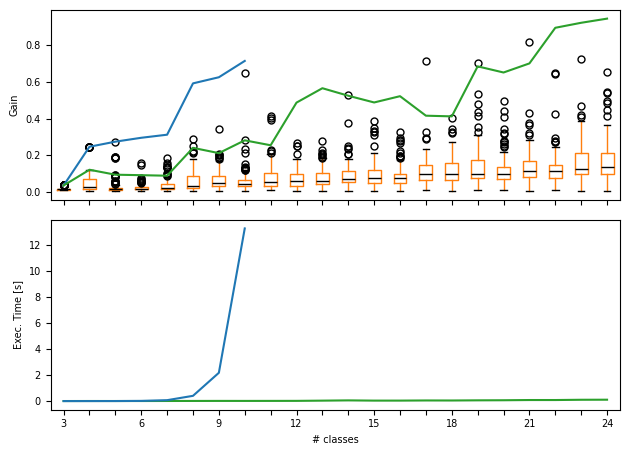

In [8]:
# width = 3.235
# # height = 1.177
# height = width / 1.618
# figsize=(width, height)
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,
                       # figsize=figsize
                       )
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)


n_classes_np = np.tile(np.array((range(i_start,i_end))), (100,1)).flatten()
df_random = pd.DataFrame({"n_classes": n_classes_np, "gain": scores.flatten()})
ax_1 = ax[0]
ax_1.set_ylabel("Gain")
# df_random.groupby('n_classes')['gain'].median().plot.line(color='C1', label='Random', ax=ax_1, x='n_classes')
boxprops = dict( color='C1')
df_random.boxplot(ax=ax_1, by='n_classes', column=['gain'],
                  showfliers=True,
                  grid=False,
                  boxprops=boxprops,
                  whiskerprops=dict(color='C1'),
                  medianprops=dict(color='black'),
                  flierprops=dict(markersize=5)
                  )
ticks = np.arange(1,23)
ax_1.plot(ticks[:8], gains_bf, label='Optimal', color='C0')
ax_1.plot(ticks, gains_greedy, label='Greedy', color='C2')
ax_1.get_figure().suptitle('')
ax_1.set_title("")
ax_1.set_xlabel("")

box = ax_1.get_position()
# ax_1.set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])

ax_2 = ax[1]
ax_2.set_xlabel("# classes")
ax_2.set_ylabel("Exec. Time [s]")
ax_2.set_xticks(np.arange(1,25))
ax_2.plot(np.arange(1,23),timestamps_greedy, label='Greedy', color='C2')
ax_2.plot(np.arange(1,22)[:8],timestamps_bf, label='Brute Force', color='C0')
ax_2.set_xticks(ticks, [3,'', '', 6, '', '', 9,'', '', 12, '', '', 15,'', '', 18,'', '', 21,'', '', 24])

# Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
# 
# ax.set_xlabel("# classes")
# ax.set_ylabel("Gain")
fig.tight_layout()
fig.show()
# fig.set_size_inches(width, height)
# fig.savefig('plot_gain.pdf', format='pdf')

/tmp/ipykernel_420923/1733411188.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


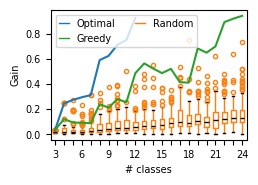

In [7]:
from matplotlib.lines import Line2D

width = 3.5 * 0.8
height = 3.5 / 1.618
# width = width * 0.725
fig, ax = plt.subplots(figsize=(width, height))

n_classes_np = np.tile(np.array((range(i_start,i_end))), (100,1)).flatten()
df_random = pd.DataFrame({"n_classes": n_classes_np, "gain": scores.flatten()})
# df_random.groupby('n_classes')['gain'].median().plot.line(color='C1', label='Random', ax=ax_1, x='n_classes')
boxprops = dict( color='C1')
df_random.boxplot(ax=ax, by='n_classes', column=['gain'],
                  showfliers=True,
                  grid=False,
                  boxprops=boxprops,
                  whiskerprops=dict(color='C1'),
                  medianprops=dict(color='black'),
                  flierprops=dict(markersize=3, markeredgecolor='C1'),
                  label='Random',
                  )
ticks = np.arange(1,23)
ax.plot(ticks[:10], gains_bf, label='Optimal', color='C0')
ax.plot(ticks, gains_greedy, label='Greedy', color='C2')
ax.get_figure().suptitle('')
ax.set_title("")
ax.set_xlabel("# classes")
ax.set_xticks(ticks, [3,'', '', 6, '', '', 9,'', '', 12, '', '', 15,'', '', 18,'', '', 21,'', '', 24])

# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])
# 
# # Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)

ax.set_xlabel("# classes")
ax.set_ylabel("Gain")
# ax.set_ylabel("Gain", loc="top", rotation="horizontal")
# ax.yaxis.set_label_coords(0, 1.05)

legend_elements = [Line2D([0], [0], color='C0', lw=1, label='Optimal'),
                   Line2D([0], [0], color='C2', lw=1, label='Greedy'),
                   Line2D([0], [0], color='C1', lw=1, label='Random')
                   ]

# 
ax.legend(
          loc='best',
          # loc='lower center', bbox_to_anchor=(0.5, 1.05),
          handles=legend_elements,
          handlelength=1,
          ncol=2,
          prop={'size': 7}
          )
# fig.set_size_inches(width, height)
# fig.tight_layout()
# fig.subplots_adjust(left=.30, bottom=.16, right=.99, top=.97)
plt.subplots_adjust(left=0.3, right=1, bottom=0.3, top=0.9)
fig.show()
# fig.savefig('plot_gain.pdf', format='pdf', bbox_inches = "tight")

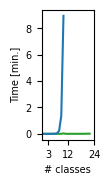

In [6]:


width = 3.5 * 0.2
# height = width / (1.618 * 0.8)
height = 3.5 / 1.618
fig, ax = plt.subplots(figsize=(width, height))

ax.set_xlabel("# classes")
ax.set_ylabel("Time [min.]")
# ax.set_ylabel("Exec. Time [s]", rotation="horizontal")
# ax.yaxis.set_label_coords(0.15, 1.05)

ax.set_xticks(np.arange(1,25))
ax.plot(np.arange(1,23),[x/60 for x in timestamps_greedy], label='Greedy', color='C2')
ax.plot(np.arange(1,22)[:10], [x/60 for x in timestamps_bf], label='Brute Force', color='C0')
ax.set_xticks([3,12,24], [3, 12, 24])
# ax.set_xticks(ticks, [3,'', '', '', '', '', '', '', '', 12, '', '', '','', '', '', '', '', '', '', '', 24])
# ax.tick_params(axis='x', which='major', bottom=False)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# ax.ticklabel_format(style='sci',scilimits=(0,0),axis='y')
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.3, top=0.9)

# fig.show()
fig.savefig('plot_runtime.pdf', format='pdf', bbox_inches = "tight")

In [70]:
s_j = np.random.randint(2, size=n_classes)

In [71]:
n_classes = spp.feature_importance.shape[0]
n_features = spp.feature_importance.shape[1]
feats_nett = s_j @ spp.feature_importance - np.transpose(np.ones(n_features) * (1 / n_features) * (np.ones(n_classes) @ s_j))

In [72]:
feats_nett

array([-0.47780659, -0.43016083, -0.44465395, -0.54705764, -0.31878165,
       -0.35737047, -0.24817604,  0.60139452,  0.94230061,  0.40575883,
        0.54219633, -0.57350748, -0.20336804,  0.6271327 ,  0.48209971])

In [73]:
colorlist = [ 'g' if feat > 0 else 'r' for feat in feats_nett]
colorlist

['r', 'r', 'r', 'r', 'r', 'r', 'r', 'g', 'g', 'g', 'g', 'r', 'r', 'g', 'g']

In [76]:
width = 3.5 * 0.5
height = 3.5 / 1.618

import matplotlib.patches as mpatches
legend_elements = [
    mpatches.Patch(color='r', label='Ignored'),
    mpatches.Patch(color='g', label='Selected'),
    # Line2D([0], [0], color='r', lw=1, ),
                   ]

fig, ax = plt.subplots(figsize=(width, height))
ax.bar(np.arange(15), feats_nett,color=colorlist)
ax.set_ylabel('Net Importance')
ax.set_xlabel('Feature Index')
ax.set_title(f'$S_i={s_j}$', size=6)
# ax.set_xticks(np.arange(spp.n_features), labels=spp.features_list, rotation=90)
ax.set_xticks([0,3,6,9,12,14], labels=[1,4,7,10,13,15])
ax.set_yticks([-1,0,1])
ax.legend(
          loc='lower left',
          # loc='lower center', bbox_to_anchor=(0.5, 1.05),
          handles=legend_elements,
          # handlelength=1,
          # ncol=2,
          prop={'size': 7}
          )
fig.show()
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.3, top=0.9)
fig.savefig('plot_feat_selection.pdf', format='pdf', bbox_inches='tight')

/tmp/ipykernel_482287/347211406.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [9]:
spp = SPP(n_classes=n_classes, n_features=n_features, unwanted_classes=unwanted_classes, weights_file=weights_file,
          f1_file=f1_file, use_case=use_case, fix_level=fix_level)

In [10]:
spp.solve_spp_greedy(gain_function=get_block_gain, show_plot_gain=False, save=False)

,Cluster,Class List,Feature List
0,0,"[Amazon Echo, Belkin Wemo switch, Belkin wemo ...","[dstport, ip.len, ip.ttl, srcport, tcp.window_..."
1,1,[Android Phone],"[dstport, ip.len, ip.ttl, srcport, tcp.window_..."
2,2,"[NEST Protect smoke alarm, Withings Smart Baby...","[dstport, ip.len, ip.ttl, srcport, tcp.window_..."
3,3,[Dropcam],"[Flow Duration, ip.len, ip.ttl, srcport, udp.l..."
4,4,"[HP Printer, MacBook]","[dstport, ip.ttl, srcport, tcp.hdr_len, tcp.wi..."
5,5,"[TP-Link Day Night Cloud camera, TP-Link Smart...","[dstport, ip.len, srcport, tcp.window_size_val..."
6,6,[PIX-STAR Photo-frame],"[dstport, ip.len, srcport, tcp.window_size_val..."


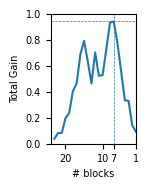

In [89]:
width = 3.5 * 0.325
height = 3.5 / 1.618

fig, ax = plt.subplots(figsize=(width, height))
ax.vlines(7,0,1,linestyle='--', linewidth=0.5)
ax.hlines(max(spp.precomputed_gains), 24, 1, linestyles='--', linewidth=0.5)
ax.plot(np.arange(23, 0, -1), spp.precomputed_gains)
ax.set_xlim(spp.n_classes, 2)
ax.set_xticks([20,10,7,1])
ax.set_ylim(0, 1)
ax.set_xlabel('# blocks')
ax.set_ylabel('Total Gain')
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.3, top=0.9)
fig.savefig('plot_block_selection.pdf', format='pdf', bbox_inches='tight')

# Complexity evaluation

In [17]:
import random
from scipy.special import softmax

In [18]:
def generate_random_W(n_classes, n_features):
    W = softmax(np.array([[random.random() for i in range(n_features)] for j in range(n_classes)]), 1)
    W_df = pd.DataFrame(W)
    W_df.insert(0, "c_name", [f"class_{i+1}" for i in range(n_classes)], True)
    # W_df = W_df.set_index("c_name", drop=True)
    W_df = W_df.rename(columns={i:f'feat_{i+1}' for i in range(n_features)})
    return W_df

In [19]:
def generate_random_F(n_classes):
    return pd.DataFrame({'class': [f"class_{i+1}" for i in range(n_classes)], 'f1_score': [random.random()*100 for i in range(n_classes)]}).set_index('class')

In [20]:
n_classes_random = 50
W_df = generate_random_W(n_classes_random, n_features)
F_df = generate_random_F(n_classes_random)

In [21]:
W_df

,c_name,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15
0,class_1,0.065244,0.040495,0.089281,0.095171,0.099496,0.053041,0.039370,0.044516,0.045213,0.094388,0.065309,0.092599,0.046231,0.042428,0.087218
1,class_2,0.071988,0.045036,0.084697,0.086878,0.074654,0.058786,0.071994,0.040396,0.074509,0.043749,0.055265,0.075903,0.069606,0.042737,0.103802
2,class_3,0.098574,0.066717,0.072522,0.070416,0.046275,0.054606,0.053552,0.064124,0.089319,0.051750,0.061061,0.051493,0.089136,0.050556,0.079899
3,class_4,0.036770,0.038590,0.040181,0.091727,0.046090,0.037523,0.085480,0.086127,0.052009,0.096183,0.084850,0.088697,0.099437,0.042529,0.073805
4,class_5,0.059063,0.066226,0.051181,0.057139,0.047520,0.090838,0.054332,0.063951,0.059542,0.044749,0.100455,0.047299,0.090533,0.057194,0.109978
5,class_6,0.063682,0.084759,0.042837,0.049064,0.095660,0.040080,0.047746,0.098025,0.067413,0.045449,0.092263,0.050511,0.070320,0.076705,0.075486
6,class_7,0.090582,0.049186,0.049638,0.081674,0.051934,0.094193,0.041887,0.058683,0.092604,0.077594,0.078609,0.089441,0.040496,0.047216,0.056263
7,class_8,0.044503,0.089416,0.076333,0.061086,0.064848,0.071239,0.040643,0.093623,0.045734,0.085487,0.048859,0.069949,0.088214,0.068011,0.052055
8,class_9,0.075536,0.078970,0.051940,0.047486,0.058998,0.059032,0.102623,0.063011,0.059396,0.063055,0.054135,0.079591,0.088849,0.062057,0.055320
9,class_10,0.082890,0.092067,0.056969,0.099623,0.064000,0.075885,0.044118,0.067811,0.050385,0.050322,0.089612,0.042056,0.068872,0.039218,0.076173


In [22]:
spp = SPP(n_classes=n_classes_random, n_features=n_features, unwanted_classes=[], weights_df=W_df,
          f1_df=F_df, use_case='random')

In [23]:
start = time.time()
spp.solve_spp_greedy(gain_function=get_block_gain, show_plot_gain=False, save=False, print_console=False)
end = time.time()
print(f'Time: {end-start}')

Time: 1.779172658920288


In [27]:
timestamps_random_greedy = []
i = 3
while len(timestamps_random_greedy) < 100:
    n_classes_random = 50
    W_df = generate_random_W(i, n_features)
    F_df = generate_random_F(i)
    spp = SPP(n_classes=i, n_features=n_features, unwanted_classes=[], weights_df=W_df,
              f1_df=F_df, use_case='random')
    try:
        start = time.time()
        spp.solve_spp_greedy(gain_function=get_block_gain, show_plot_gain=False, save=False, print_console=False)
        end = time.time()
        timestamps_random_greedy.append(end - start)
        i = i + 1
    except ValueError:
        continue

Text(0.5, 0, '# classes')

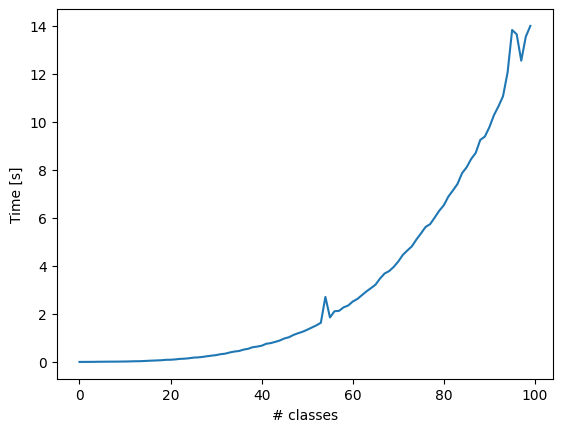

In [30]:
plt.plot(timestamps_random_greedy)
plt.ylabel('Time [s]')
plt.xlabel('# classes')

In [38]:
import itertools

elements = []
for j in range(1000):
    elements.append(len(list(itertools.combinations([i for i in range(j)], 2))))

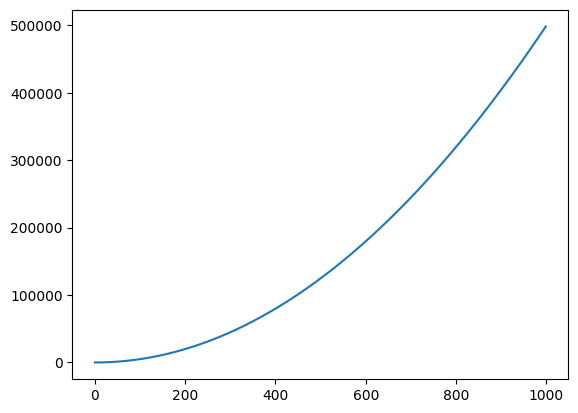

In [39]:
plt.plot(elements)